# Machine Learning Engineer Nanodegree

## Unsupervised Learning

## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() 
                                    # for DataFrames

# Show matplotlib plots inline 
# (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print ( "Wholesale customers dataset has "
            "{} samples with {} features each.".format(*data.shape) )
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


In [2]:
### Used for segment analysis in Questions 8+
def draw_boxplots(data, samples=None, cluster_centers=None,
                  column_labels=None, sample_labels=None,
                  title=None, return_key=True):
    # type: (pandas.DataFrame, pandas.DataFrame, list[str],
    #        pandas.DataFrame, list[str], str) -> str

    """Draw n box plots from a DataFrame with n columns onto current canvas.
    
    Returns key for point shapes and colors. The canvas must already 
    have been instantiated and can include figures or subplots.
    
    Optionally, sample points and cluster center points can be 
    overlaid onto the box plots, and must be DataFrames with the same
    columns as in ``data``.
    
    Note:
        Cluster label postions' offset values are hard-wired.
            Recommended figure sizes for best label positioning:
                No subplots:       plt.figure(figsize=[10,11])
                2 subplots, 1 row: plt.figure(figsize=[14,8])
    
    Args:
        data (pandas.DataFrame): Used for box plots, n columns
        samples (pandas.DataFrame, optional): Sample data points 
            to be plotted over box plots, n columns
        cluster_centers (pandas.DataFrame, optional): Cluster mean points
            to be plotted over box plots, n columns
        column_labels (list[str], optional): Labels for each box plot,
            shown below y-axis, defaults to DataFrame column names, n columns
        sample_labels (list[str], optional): Labels for sample, used for
            for returned key string
        title (str, optional): Plot title.
        return_key (bool, optional): Default is to return key string.
        
    Returns:
        String containing key for plot
        
    Todo:
        * Convert if statements to try/except where appropriate
    """
    
    SAMPLE_POINT_COLORS = ['g', 'y', 'c']
    SAMPLE_POINT_SHAPE = 'D'  # large diamonds

    CLUST_MEAN_COLORS = ['k']*2  # black
    CLUST_MEAN_SHAPE = '*'  # Xs
    
    CLUST_LBL_OFFSET = [-.2, -.05]

    plt.title(title if title is not None else '')

    plt.boxplot(data.transpose().values.tolist(),
                labels=column_labels)

    for x, col in enumerate(data.keys(), 1):
        if pd.DataFrame not in (type(samples), type(cluster_centers)):
            break
        
        if samples is not None:
            for i, (_, sample) in enumerate(samples.iterrows()):
                sample_point_style = ( SAMPLE_POINT_SHAPE
                                     + SAMPLE_POINT_COLORS[i] )    
                y = sample[col]
                plt.plot(x, y, sample_point_style)

        if cluster_centers is not None:
            for i in range(cluster_centers.shape[0]):
                cluster_mean_style = ( CLUST_MEAN_SHAPE
                                     + CLUST_MEAN_COLORS[i] )
                y = cluster_centers[col][i]
                plt.plot(x, y, cluster_mean_style)
                cluster_label = 'c' + cluster_centers.index[i][-1]
                plt.annotate(cluster_label, xy=(x, y), 
                             xytext=(x+CLUST_LBL_OFFSET[0],
                                     y+CLUST_LBL_OFFSET[1]))

    
    if return_key is True:
        if pd.DataFrame in (type(samples), type(cluster_centers)):
            key = '******* Key *******\n'
            if cluster_centers is not None:
                key += 'stars    = segment means\n'

            if pd.DataFrame in (type(samples), type(cluster_centers)):
                key += ('diamonds = sample points\n'+
                        '  green  = {}\n  yellow = {}\n  cyan   = {}'
                        .format(*sample_labels))
            return key

## Data Exploration

In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [3]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
import seaborn as sns
from scipy.stats import boxcox, distributions, probplot
from scipy.stats.mstats import zscore

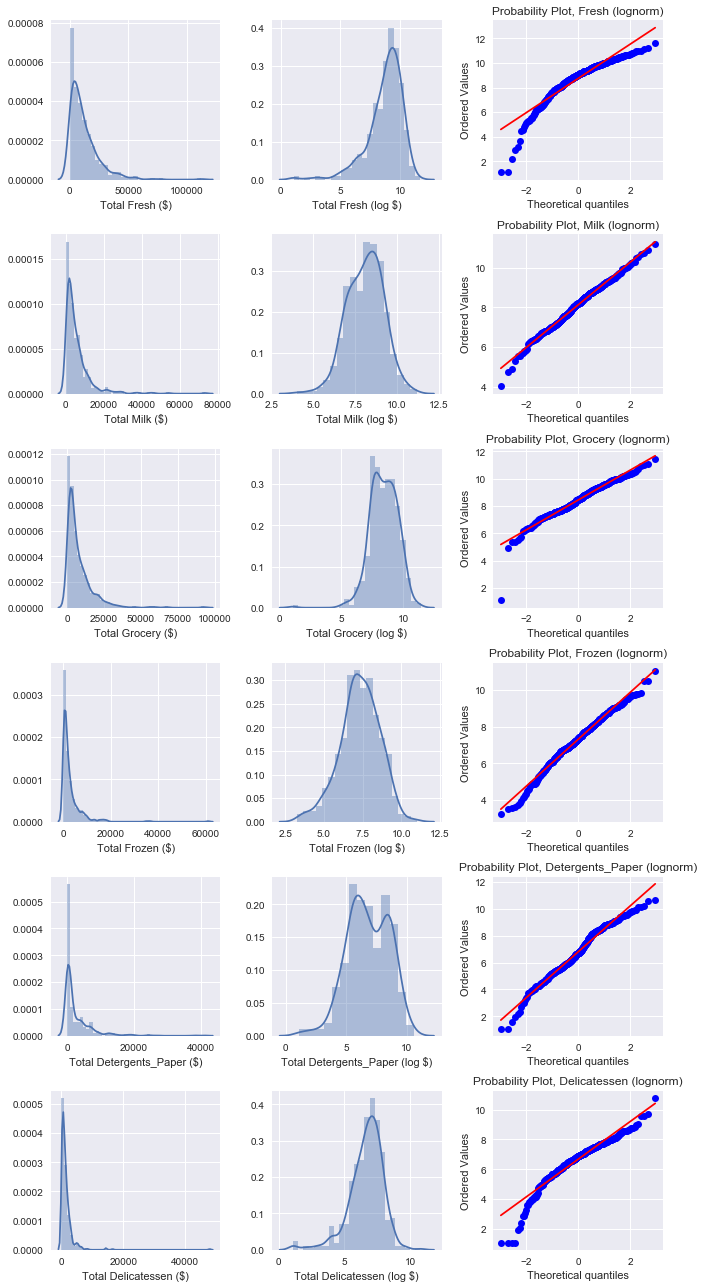

In [5]:
log_data = np.log(data)

_, nfeats = data.shape
fig, axes = plt.subplots(ncols=3, nrows=nfeats,
                        figsize=(10, 18))

for axs, dat, log_dat in zip(axes, data.iteritems(), log_data.iteritems()):
    ax, log_ax, pp_ax = axs
    name, vals = dat
    _, log_vals = log_dat
    
    sns.distplot(vals, axlabel='Total '+name+' ($)', ax=ax)
    sns.distplot(log_vals, axlabel='Total '+name+' (log $)', ax=log_ax)
    probplot(log_vals, plot=pp_ax)
    pp_ax.set_title('Probability Plot, '+name+' (lognorm)')

plt.tight_layout()
plt.show()

### Implementation: Selecting Samples

To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [6]:
# TODO: Select three indices of your choice 
# you wish to sample from the dataset

deli = data.idxmax(axis=0)['Delicatessen']
market = data.idxmax(axis=0)['Fresh']
grocery_store = 200  # manually selected

sample_indices = [deli, market, grocery_store]

# Create a DataFrame of the chosen samples
samples = data.loc[sample_indices, :]

print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
183,36847,43950,20170,36534,239,47943
181,112151,29627,18148,16745,4948,8550
200,3067,13240,23127,3941,9959,731


**Answer:**
- `[0]:` Deli
    - Sample 0 has the highest Delicatessen spending of all customers and moderate to high spending on all other categories except Detergents & Paper, indicating that they primarily buy ingredients with just a few non-food items likely for office use.
- `[1]:` Large produce-oriented market
    - Sample 1 has the highest Fresh spending relative to the rest of the data. Otherwise, they spend more than most customers on the other categories but far less relative to their Fresh spending.
- `[2]:` Medium-sized grocery store
    - This sample (2) spends on the moderate-high end of the scale for essentials: Milk, Grocery, Frozen and Detergents & Paper. For the other categories, Fresh and Delicatessen, they spends much less than most of the other customers. Significantly, they spend the most on Milk and Grocery. All of this indicates a grocery store that does not emphasize Fresh produce.

#### Alternative sample selection (stratified from total spending)

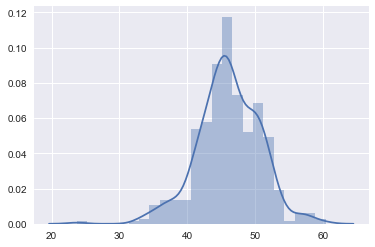

In [7]:
SEED = 42

log_tots = np.log(data).sum(axis=1)
sns.distplot(log_tots, hist_kws=dict(cumulative=False));

In [8]:
max_, x, std = log_tots.max(), log_tots.mean(), log_tots.std()
bins = x-std, x+std, max_

indices = np.digitize(log_tots, bins, right=True)
grouped = log_tots.groupby(indices)

stratif_sample_idx = grouped.apply(lambda x: x.sample(n=1, random_state=SEED))
stratif_sample_idx = stratif_sample_idx.index.levels[1].values

stratif_samples = data.loc[stratif_sample_idx, :]
print "Chosen samples of wholesale customers dataset:"
display(stratif_samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
27,14276,803,3045,485,100,518
112,19046,2770,2469,8853,483,2708
347,27380,7184,12311,2809,4621,1022


### Question 1

Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

### Implementation: Feature Relevance

One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

# Global constants
TEST_PROPORTION = 0.25

r_2_scores = []

for target in data.keys():
    # TODO: Make a copy of the DataFrame, using the 
    # 'drop' function to drop the given feature
    X_all = data.drop([target], axis=1, inplace=False)
    y_all = data[target]

    # TODO: Split the data into training and testing 
    # sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(
                                        X_all, y_all,
                                        test_size=TEST_PROPORTION,
                                        random_state=SEED )

    # TODO: Create a decision tree regressor and fit it 
    # to the training set
    regressor = DecisionTreeRegressor(random_state=SEED)
    regressor.fit(X_train, y_train)

    score = regressor.score(X_test, y_test)
    r_2_scores.append( (target, score) )

# Sort categories from highest to lowest R^2 scores
r_2_scores.sort(reverse=True, key=lambda elem: elem[1])

# TODO: Report the score of the prediction using the testing set
for category, score in r_2_scores:
    print 'R^2 = {:>5.2f}  ({})'.format(score, category)

R^2 =  0.68  (Grocery)
R^2 =  0.27  (Detergents_Paper)
R^2 =  0.16  (Milk)
R^2 = -0.21  (Frozen)
R^2 = -0.39  (Fresh)
R^2 = -2.25  (Delicatessen)


/Users/mdlynch37/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Compared with transformed data (done later)

```python
# No transformation:
R^2 =  0.68  (Grocery)
R^2 =  0.27  (Detergents_Paper)
R^2 =  0.16  (Milk)
R^2 = -0.21  (Frozen)
R^2 = -0.39  (Fresh)
R^2 = -2.25  (Delicatessen)

# With log transformation done later:
R^2 =  0.60  (Grocery)
R^2 =  0.43  (Milk)
R^2 =  0.38  (Detergents_Paper)
R^2 = -0.59  (Delicatessen)
R^2 = -0.65  (Frozen)
R^2 = -0.66  (Fresh)
```

In [10]:
data.corr(method='pearson')

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


In [11]:
data.corr(method='spearman')

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,-0.083921,-0.119983,0.384395,-0.198333,0.238400
Milk,-0.083921,1.000000,0.773049,-0.092971,0.679979,0.372771
Grocery,-0.119983,0.773049,1.000000,-0.168831,0.801282,0.304256
Frozen,0.384395,-0.092971,-0.168831,1.000000,-0.207183,0.233024
Detergents_Paper,-0.198333,0.679979,0.801282,-0.207183,1.000000,0.183314
Delicatessen,0.238400,0.372771,0.304256,0.233024,0.183314,1.000000


### Question 2

*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

- $R^{2}$ scores for all categories shown in results above.
- Let's focus on our analysis on the attempt to predict the Grocery feature: 
    - $R^{2} = 0.681884$ (the reported prediction score)
- From the score we can see that grocery spending is a somewhat decent (and you could say necessary) indicator of a client's buying habits across all product categories.

### Visualize Feature Distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

In [12]:
# Produce a scatter matrix for each pair of features in the data
if False:  # see next section for scatter matrix of *scaled data*
    sns.pairplot(data);

### Question 3

*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**
- Yes, Grocery and Milk show some degree of correlation, along with Grocery and Detergents_Paper.
- This confirms my response to Question 2.
- Descriptions for the distributions of those three features are as follows:
    - _Grocery_ : skewed right, unimodal and non-normal
    - _Milk_ : skewed right but less so than Grocery, unimodal and non-normal with a few outliers
    - _Detergents_\__Paper_ : skewed right more than the other two, unimodal and non-normal with some outliers

## Data Preprocessing

In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling

If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

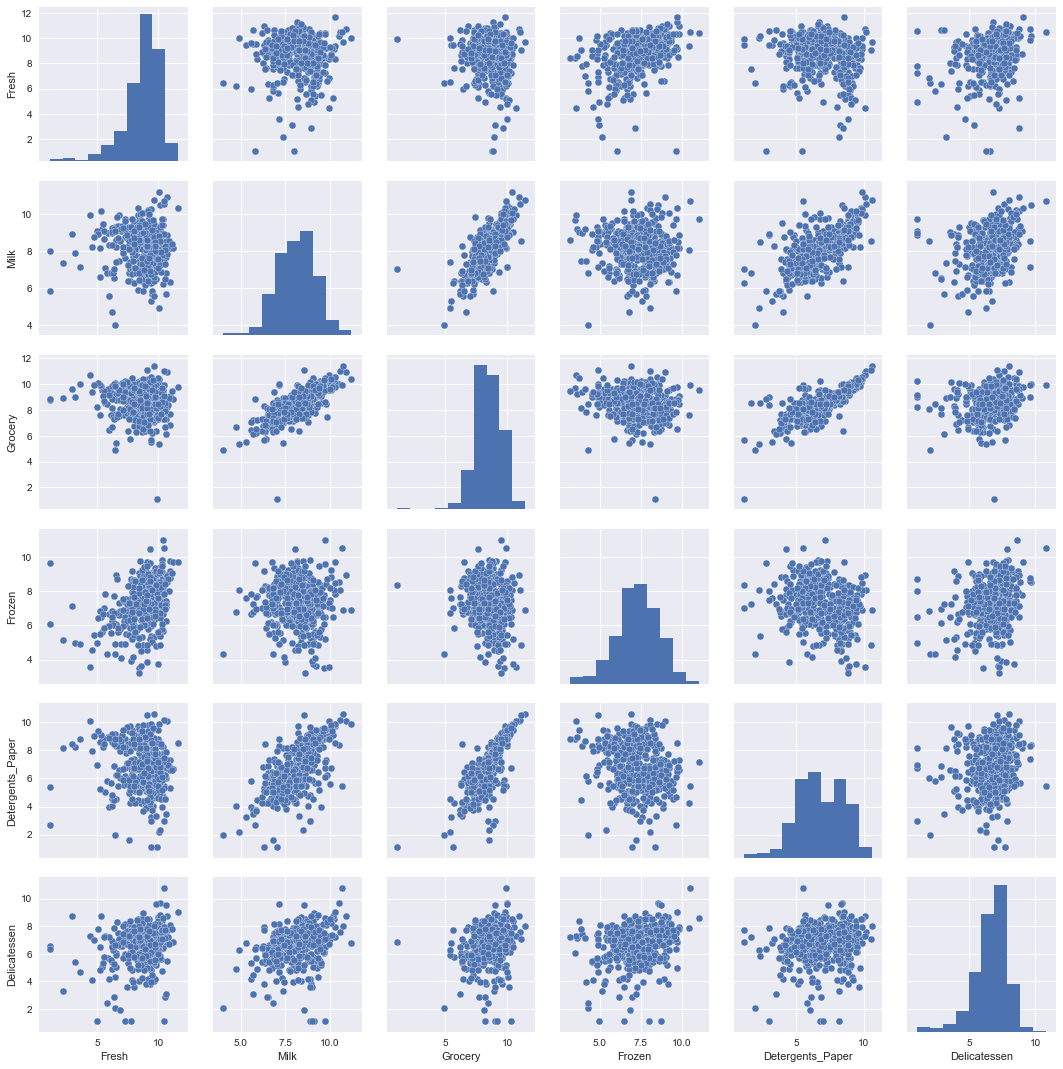

In [13]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)  # done earlier, not difference

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
sns.pairplot(log_data);

#### Alternative feature scaling

In [14]:
def boxcox_standardize(df):
    """Scale and standardize features with Box-Cox algorithm."""
    df += 100
    cols = []
    for name, col in df.iteritems():
        vals, _ = boxcox(col)
        vals = zscore(vals)
        cols.append(pd.Series(vals, name=name))
        
    df = pd.concat(cols, axis=1)
    return df

cb_data = boxcox_standardize(data)

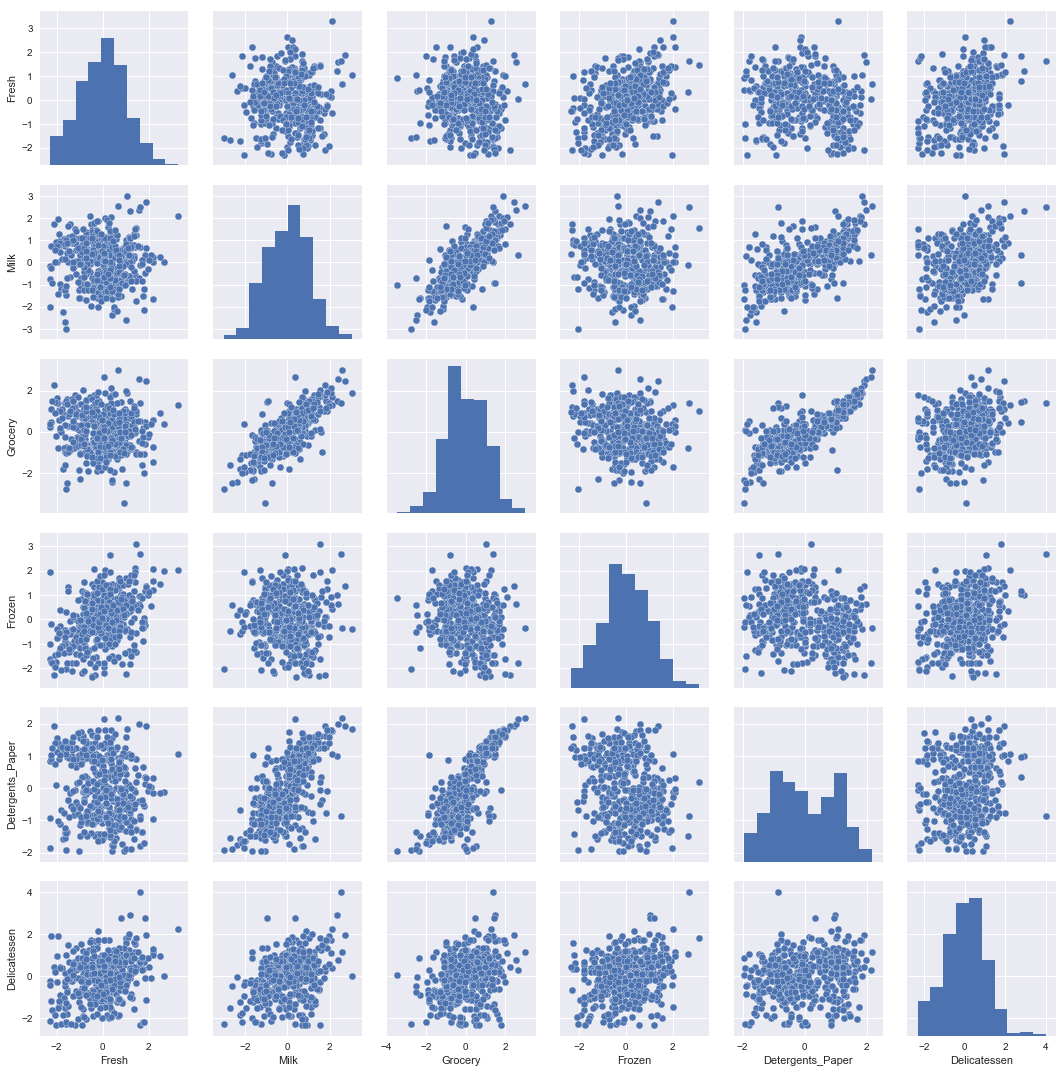

In [15]:
sns.pairplot(cb_data)

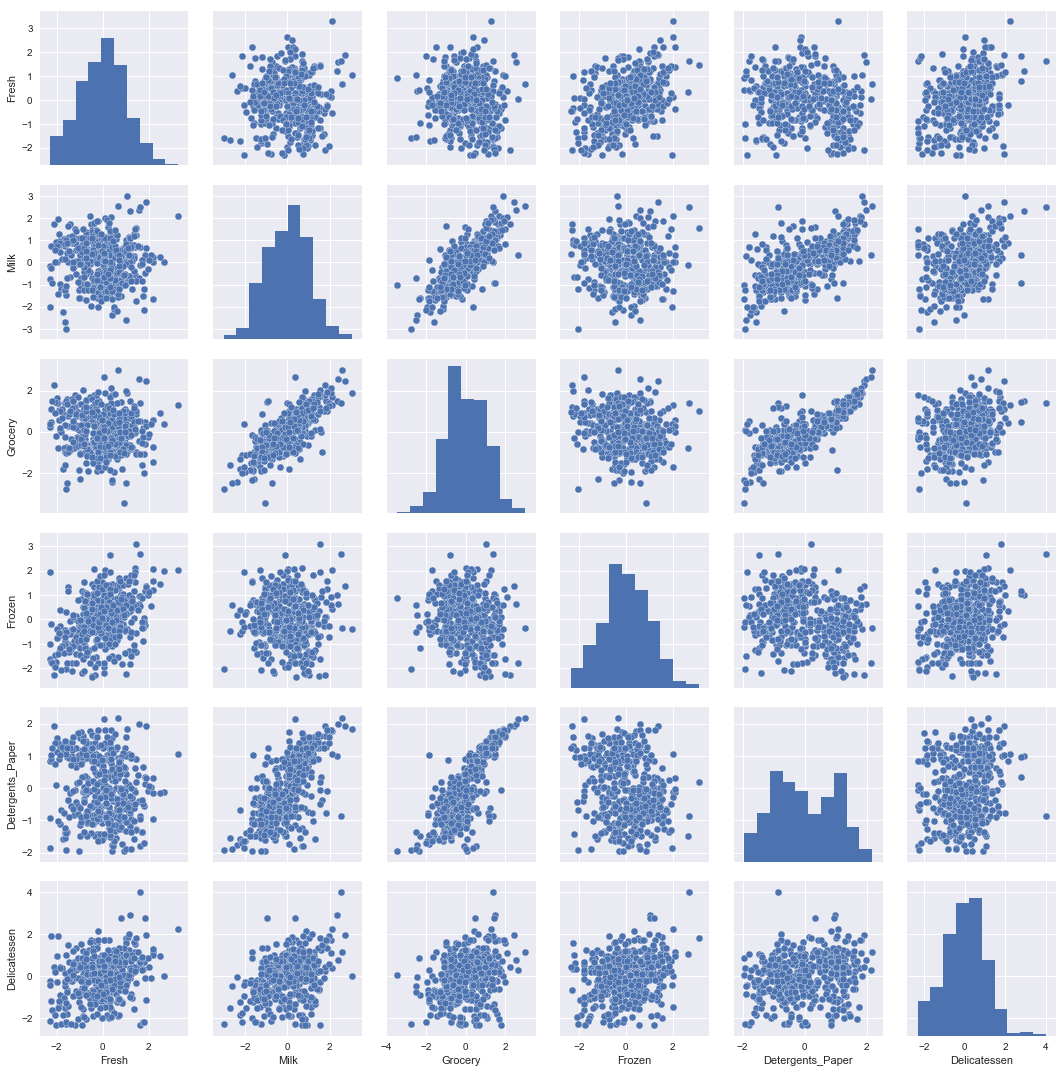

In [16]:
sns.pairplot(cb_data)

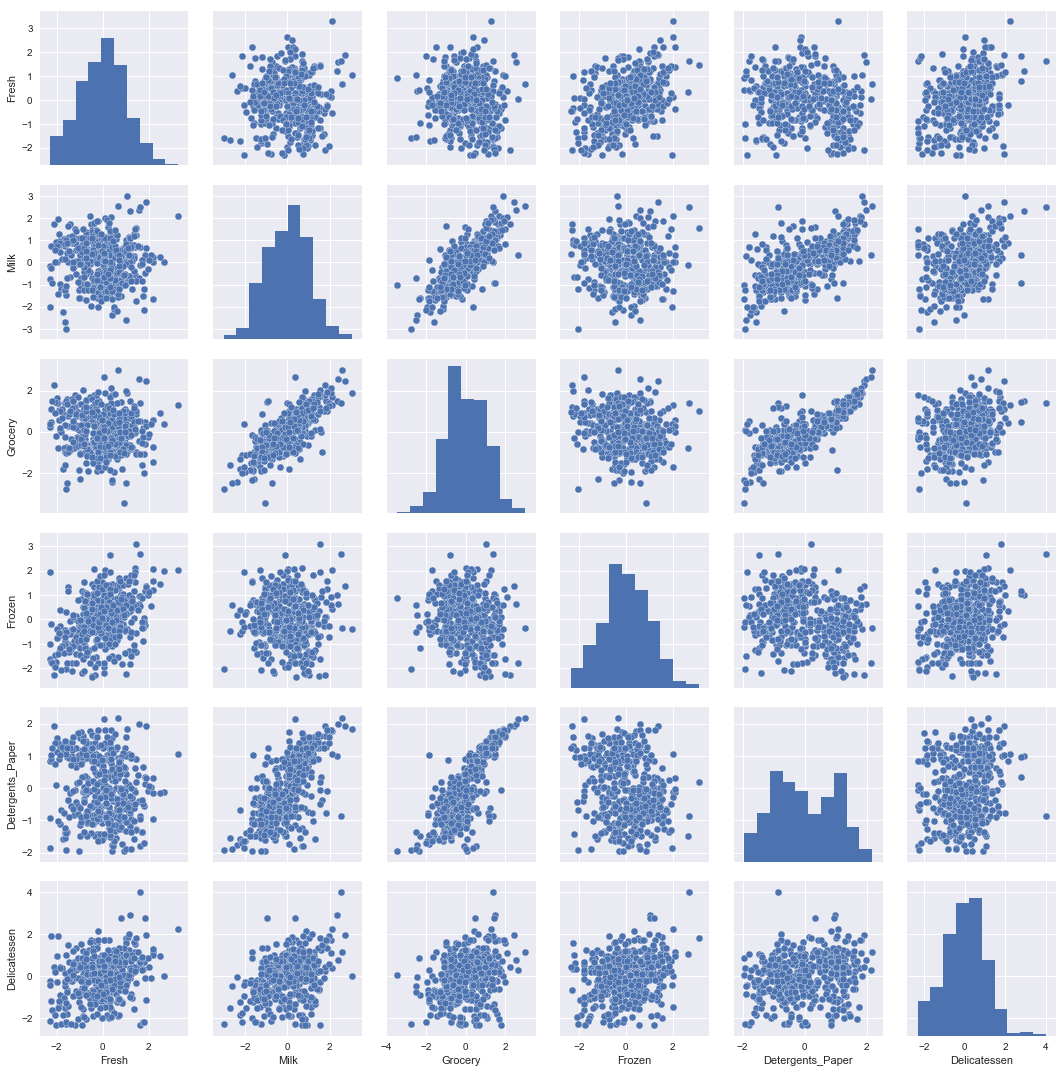

In [17]:
sns.pairplot(cb_data)

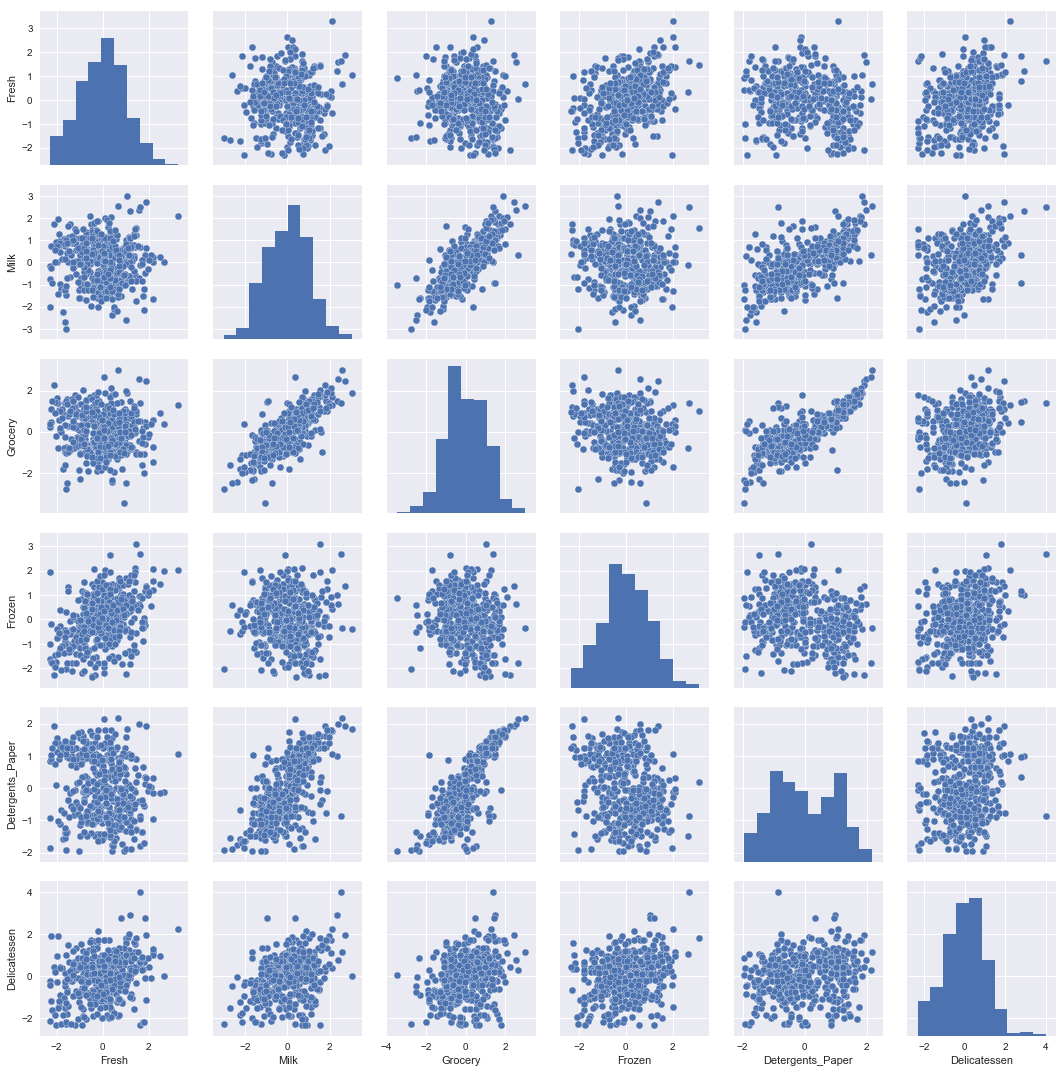

In [18]:
sns.pairplot(cb_data)

In [19]:
4.996726e+00

4.996726

### Observation

After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [20]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
181,11.627601,10.296441,9.806316,9.725855,8.506739,9.053687
200,8.028455,9.490998,10.048756,8.279190,9.206232,6.594413


### Implementation: Outlier Detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [21]:
def is_outlier_val(col):
    """Detects outliers using Tukey's method.
    
    Technique determines an outlier if it fall outside
    the interquartile range expanded by 50% on either side.
    
    Parameters
    ----------
    col : pandas.Series
        Specific feature to be assessed
    
    Returns
    -------
    result : pandas.Series
        Of boolean values, true if value is outlier
    """
    q1, q3 = col.quantile(q=.25), col.quantile(q=.75)
    step = 1.5 * (q3-q1)
    lo, hi = q1-step, q3+step
    
    result = (col<lo) | (col>hi)
    return result

def outlier_instances(df, thresh=2, col_func=is_outlier_val):
    """Determines outliers from multiple features.
    
    Parameters
    ----------
    df : pandas.DataFrame
    thresh : int, default=2
        Specifies how many outlier values must be present
        to identify an instance as an outlier.
        
    Returns
    -------
    outliers : pandas.DataFrame
    """
    is_outlier = df.apply(col_func).sum(axis=1) >= thresh
    outliers = df[is_outlier]
    
    return outliers

outliers = outlier_instances(log_data)
outliers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


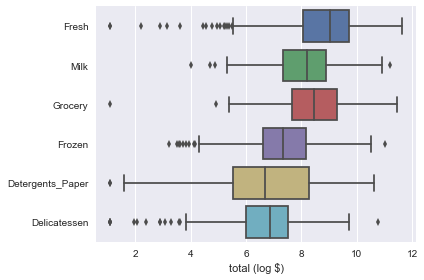

In [22]:
sns.boxplot(data=log_data, orient='h')
plt.xlabel('total (log $)')
plt.tight_layout()

In [23]:
# Remove the outliers, if any were specified
good_data = log_data.drop(outliers.index)

### Question 4

*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**
- There are a handful of data points that are outliers based on more than one feature.
    - One data point meets the criterion for three features, while four do based on two features as shown in the filtered `DataFrame`s above.
- These extreme outliers were removed from the dataset because could add more noise to the dataset which would decrease the performance of our learner.

## Feature Transformation

In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

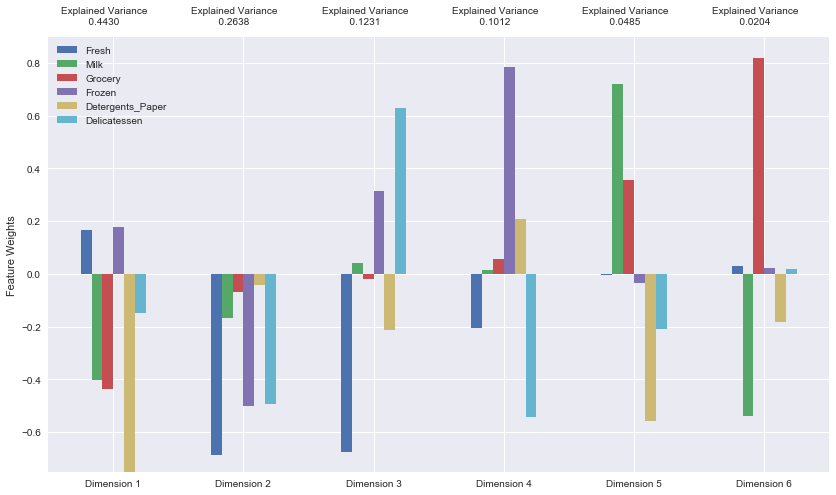

In [24]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with 
# the same number of dimensions as features
pca_6d = PCA(n_components=6)
pca_6d.fit(good_data)

# TODO: Transform the sample log-data using 
# the PCA fit above
pca_6d_samples = pca_6d.transform(log_samples)

# Generate PCA results plot
pca_6d_results = rs.pca_results(good_data, pca_6d)

### Question 5

*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

#### Answer:

_5.1._ Proportion of variance explained in total by PC1 and PC2:

In [25]:
result = sum(pca_6d.explained_variance_ratio_[:2])
print('PC1 + PC2\n= {:.2f}'.format(result))

PC1 + PC2
= 0.71


_5.2._ Proportion of variance explained in total by PCs 1-4:

In [26]:
result = sum(pca_6d.explained_variance_ratio_[:4])
print('PC1 + PC2 + PC3 + PC4\n= {:.2f}'.format(result))

PC1 + PC2 + PC3 + PC4
= 0.93


_5.3._ Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending:

- D1 puts a significant pos. weigth on Detergents and Paper, with some on Milk and Grocery as well. This is best described as generic minimum grocery store goods.
- D2 puts significant pos. weight on Fresh, Frozen and Deli, which represents spending by large stores that have enough scale to afford lots expensive equipment like freezers, as well as Deli staff and equipment.
- D3 puts a high pos. weight on Delicatessen spending, with a significant neg. weight on Fresh spending. This represents spending by establishments that put a high emphasis on their Deli and prepared goods.
- D4 puts a significant pos. weight on Frozen spending, with a significant neg. weight Delicatessen spending. Since this does not correspond with any particular type of store, we can say that this dimension loosely represents a establishments that both sell lots of Frozen goods and very few Deli items.

### Observation

Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [27]:
# Display sample log-data after having a PCA
# transformation applied
pca_6d_samples_df = pd.DataFrame(np.round(pca_6d_samples, 4),
                                 columns=pca_6d_results.index.values,
                                 index=log_samples.index)

display(log_samples)
display(pd.concat([pca_6d_samples_df, pca_6d_samples_df.describe()]))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
181,11.627601,10.296441,9.806316,9.725855,8.506739,9.053687
200,8.028455,9.490998,10.048756,8.279190,9.206232,6.594413


,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
183,-0.423200,-5.284200,2.739600,-0.236400,2.133100,0.245200
181,-2.189900,-4.860500,0.000800,0.482700,0.504100,-0.198800
200,-2.990300,-0.364500,0.252100,1.565300,0.192200,0.124400
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,-1.867800,-3.503067,0.997500,0.603867,0.943133,0.056933
std,1.313511,2.726322,1.513926,0.906941,1.042274,0.229560
min,-2.990300,-5.284200,0.000800,-0.236400,0.192200,-0.198800
25%,-2.590100,-5.072350,0.126450,0.123150,0.348150,-0.037200
50%,-2.189900,-4.860500,0.252100,0.482700,0.504100,0.124400
75%,-1.306550,-2.612500,1.495850,1.024000,1.318600,0.184800


### Implementation: Dimensionality Reduction

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [28]:
# simpler to slice original pca! 
# n_components PCA param does just that.

# TODO: Apply PCA by fitting the good data 
# with only two dimensions
pca_2d = PCA(n_components=2)
pca_2d.fit(good_data)

# TODO: Transform the good data using
# the PCA fit above
reduced_data_2d = pca_2d.transform(good_data)

# TODO: Transform the sample log-data using
# the PCA fit above
reduced_samples_2d = pca_2d.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data_2d = pd.DataFrame(reduced_data_2d,
                               columns=['Dimension 1', 'Dimension 2'])

### Observation

Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [29]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(reduced_samples_2d, 4),
                     columns=['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-0.4232,-5.2842
1,-2.1899,-4.8605
2,-2.9903,-0.3645


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

Advantages of K-Means:
- One of the faster clustering algorithms.
- General purpose.
- Few parameters, not much tuning needed.
- _Disadvantages:_
    - challenging to decide how many clusters to try
    - needs a few restarts because it can get stuck in local minima

Advantages of Gaussian Mixture Model:
- Makes soft assignments of data points to clusters
    - i.e. data points are assessed to have probabilities of which cluster each might belong to, and so data points can be reassigned to another clusters after they have been assessed.
    - More of a Bayesian approach compared to hard assignment done by K-Means.
- _Disadvantages:_
    - Does not handle clusters with few data points well.
    - Known to diverge and find solutions with infinite likelihood
    - Requires more tuning of parameters.

Justification for choosing K-Means:
- Given that this project is exploratory, K-Means's out-of-the-box functionality is preferable.
- Since there are not that many samples, it is likely that certain customer segments will have only a few data points.
    - Given that, a Gaussian Mixture Model algorithm will likely struggle to identify those clusters accurately.

_Sources:_
- scikit-learn's [Overview of Clustering](http://scikit-learn.org/stable/modules/clustering.html)
- K-Means in scikit-learn [User Guide](http://scikit-learn.org/stable/modules/clustering.html#k-means)
- Gaussian Mixture Model in scikit-learn [User Guide](http://scikit-learn.org/stable/modules/mixture.html)
- What is the difference between K-means and the mixture model of Gaussian? on [Quora](https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian)
- Cluster Gaussian Mixture Data Using Soft Clustering, [MathWorks](http://www.mathworks.com/help/stats/cluster-gaussian-mixture-data-using-soft-clustering.html)

### Implementation: Creating Clusters

Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

0.426281015469


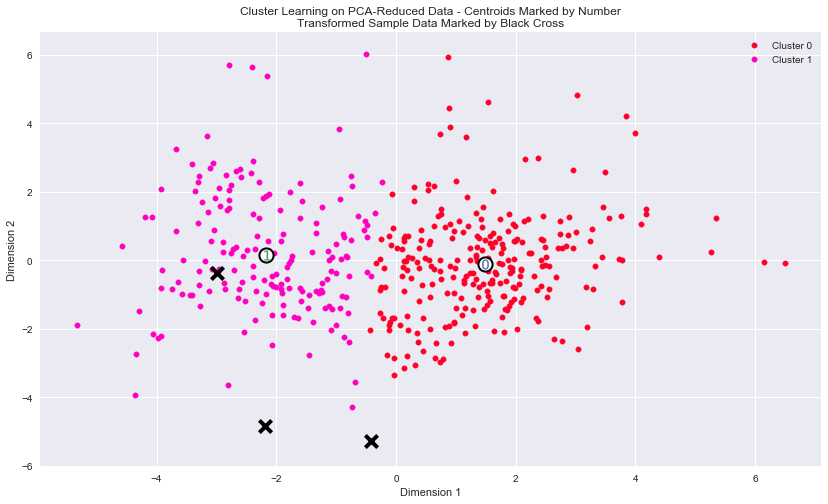

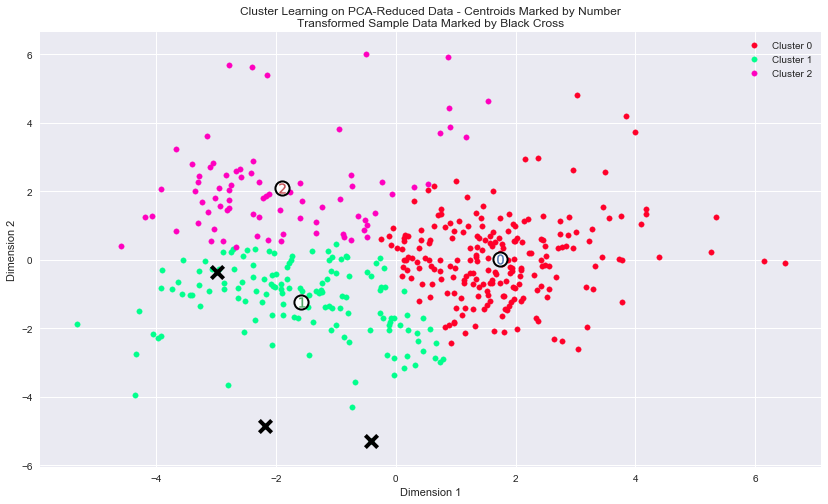

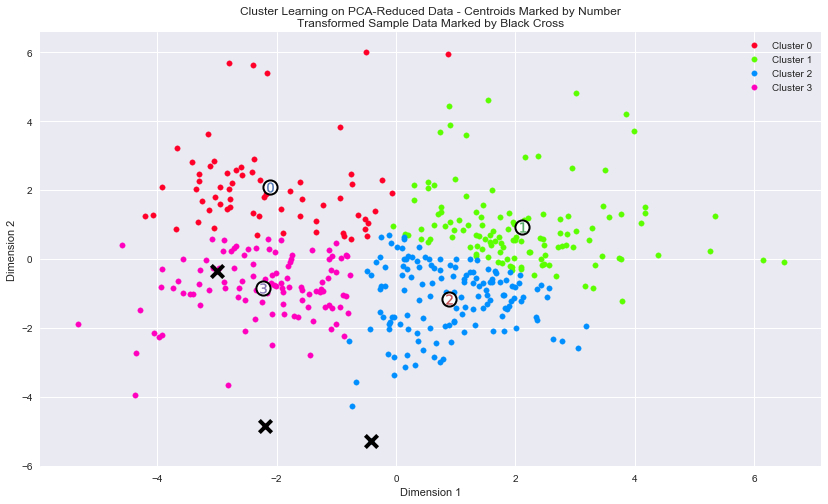

In [30]:
from collections import namedtuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

MIN_CLUSTERS = 2  # min must be >= 2
MAX_CLUSTERS = 4

scores = []

for n in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    # TODO: Apply your clustering algorithm of choice to the reduced data   
    clusterer = KMeans(n_clusters=n, random_state=SEED)
    clusterer.fit(reduced_data_2d)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data_2d)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_samples_2d)

    # TODO: Calculate the mean silhouette coefficient for 
    # the number of clusters chosen
    score = silhouette_score(reduced_data_2d, preds)
    scores.append((n, score))
    rs.cluster_results(reduced_data_2d, preds, 
                       centers, reduced_samples_2d)

# Fit the clusterer with optimal n_clusters param
scores.sort(reverse=True, key=lambda elem: elem[1])
best_n_clust = scores[0][0]

clusterer = KMeans(n_clusters=best_n_clust, random_state=SEED)
clusterer.fit(reduced_data_2d)

preds = clusterer.predict(reduced_data_2d)
sample_preds = clusterer.predict(reduced_samples_2d)

centers = clusterer.cluster_centers_
score = silhouette_score(reduced_data_2d, preds)

print score

### Question 7

*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

In [31]:
print best_n_clust, 'clusters are optimal'
print
for n, s in scores:
    print '{} clusters = {:.2f}'.format(n, s)

2 clusters are optimal

2 clusters = 0.43
3 clusters = 0.40
4 clusters = 0.33


### Cluster Visualization

Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

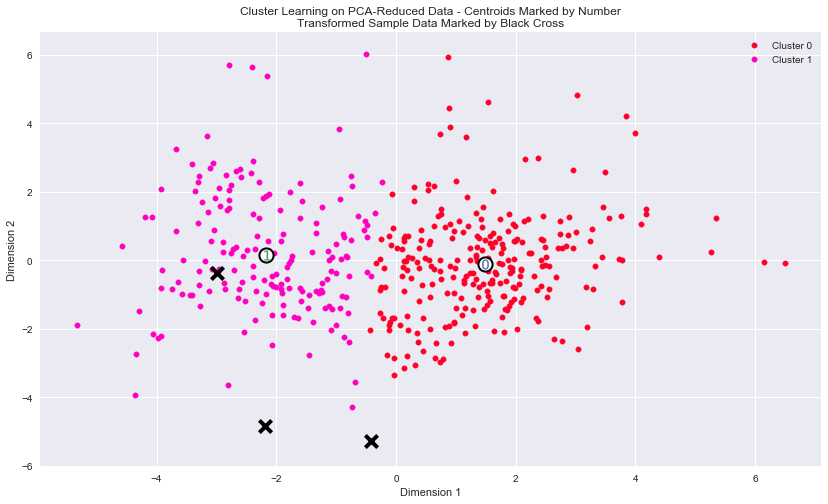

In [32]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data_2d, preds, centers, reduced_samples_2d)

#### Deeper Cluster Visualizations/Comparisons

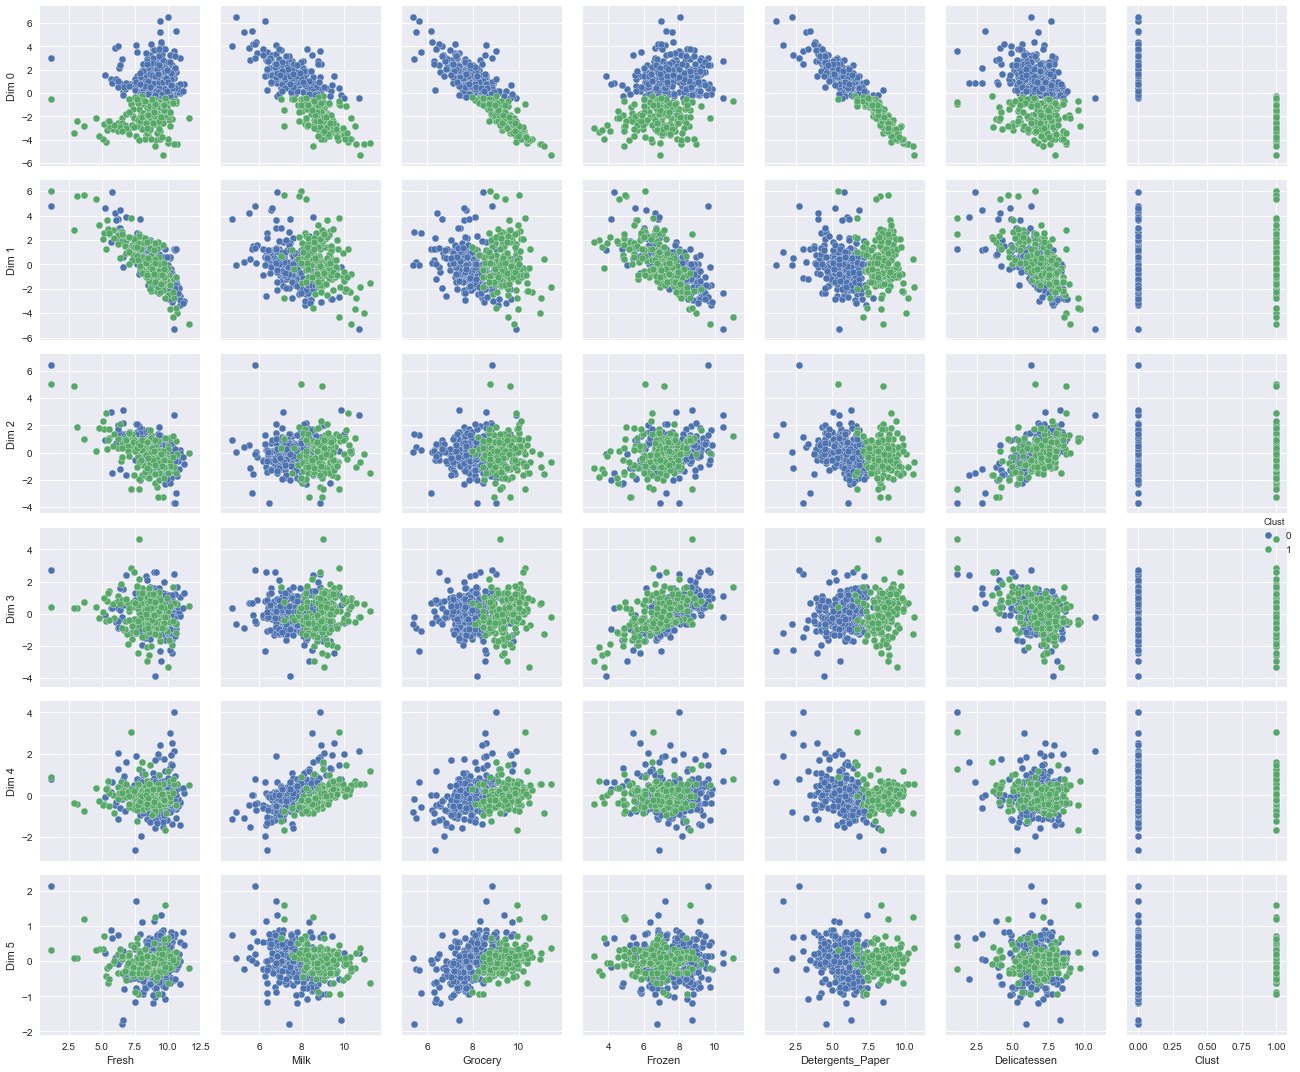

In [33]:
N_DIMS = 6
dim_cols = [' '.join(['Dim', str(i)]) for i in range(N_DIMS)]

pca = PCA(n_components=N_DIMS).fit(good_data)
pca_df = pd.DataFrame(pca.transform(good_data),
                      index=good_data.index,
                      columns=dim_cols)
preds_series = pd.Series(preds, index=good_data.index, name='Clust')

df_comb_pca = pd.concat([pca_df, good_data, preds_series], axis=1)

sns.pairplot(x_vars=good_data.columns.tolist()+['Clust'],
             y_vars=dim_cols, hue='Clust', data=df_comb_pca)

plt.tight_layout()

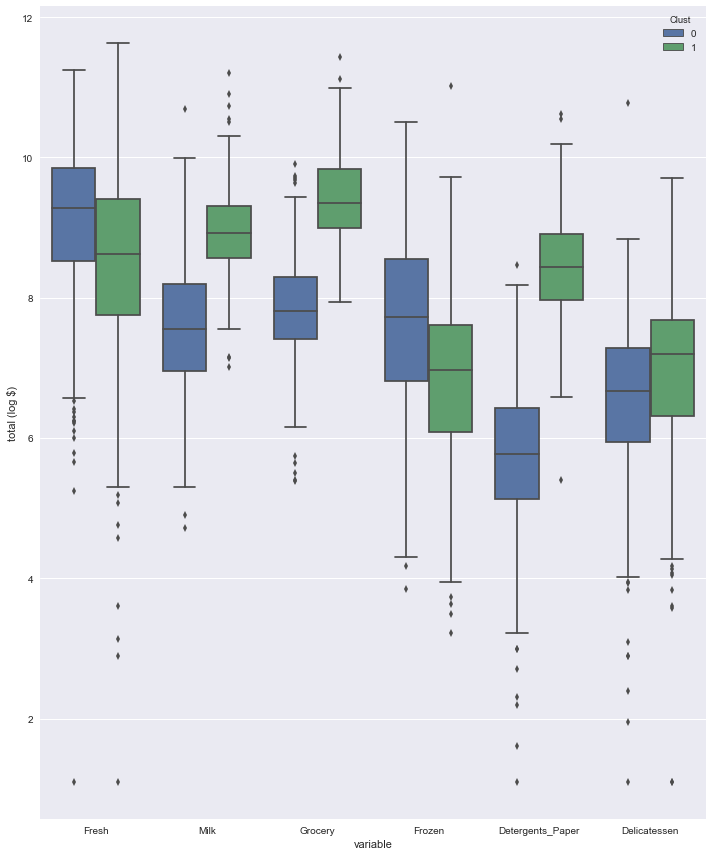

In [34]:
tots = good_data.sum(1).rename('Total')
df_comb = pd.concat([good_data, tots, preds_series], axis=1)

def plot_pboxes(df, val_label, figsize=(10, 12),
                fig_kws=None, boxplot_kws=None):
    """Plots boxplots to compare cluster distributions.
    
    Boxplots for clusters are grouped by variable.
    
    Parameters
    ----------
    df : pandas.DataFrame
    val_label : str
        Description of values for y-axis label
    figsize : tuple of width and height. default is (10, 15)
        Passed to plt.subplots to customize figure
    {fig, boxplot}_kws : dicts, optional
        Dictionaries of keyword arguments.  
    """
    fig_kws  = {} if fig_kws  is None else fig_kws
    boxplot_kws = {} if boxplot_kws is None else boxplot_kws
    
    df = pd.melt(df, id_vars='Clust', value_name=val_label)
    
    fig, ax = plt.subplots(figsize=figsize, **fig_kws)
    sns.boxplot(x='variable', y=val_label, hue='Clust', data=df, 
                ax=ax, **boxplot_kws)
    plt.tight_layout()

plot_pboxes(df_comb.drop('Total', axis=1), 'total (log $)')

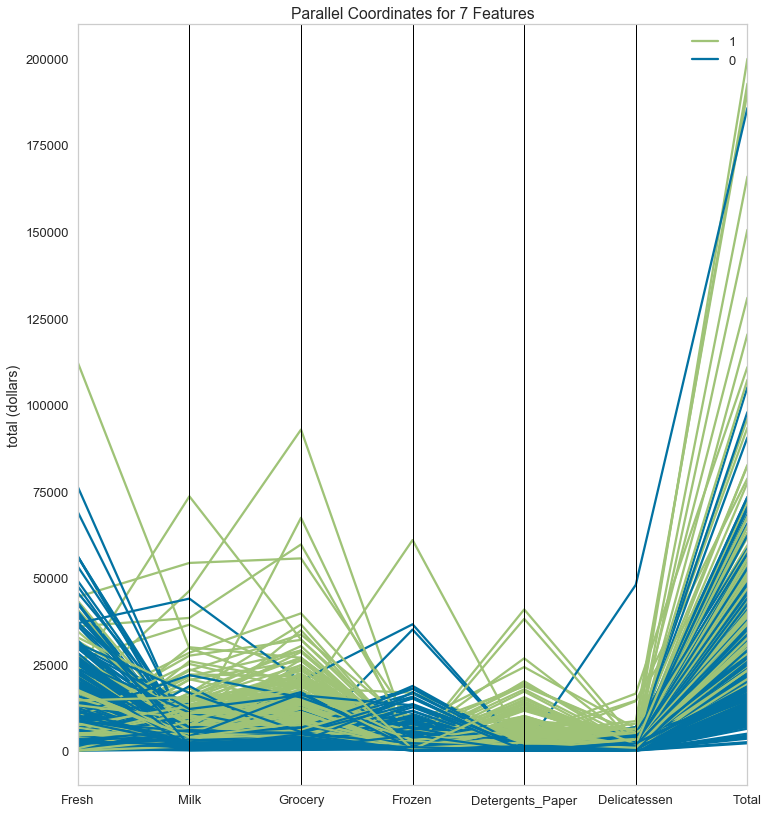

In [35]:
from yellowbrick.features.pcoords import ParallelCoordinates

def make_subclusts(df):
    """Split clusters by their cluster medians.
    
    Clusters labels will be converted into pairs with
    formula x*2 plus 0 or 1 if row's total is below or
    above the cluster's median total, respectively, using
    helper function update_clusts.
    """
    def update_clusts(group):
#         pdb.set_trace()
        med = group.Total.median()
        group.Clust = group.apply(lambda row: row.Clust if row.Total<med 
                                  else row.Clust+1, axis=1)
        return group
    
    df = df.copy()
    df.Clust *= 2
    df = df.groupby('Clust').apply(update_clusts)
    
    return df

def plot_pcoords(df, ylabel, cls_col='Clust',
                 splitclusts=False, figsize=(12, 14)):
    """Plots ParallelCoordinates, optional split clusters by median.
    
    Uses yellowbrick.ParallelCoordinates to compare clusters
    across variables. For a more textured comparison, there
    is an option to split clusters by median.
    
    Parameters
    ----------
    df : pandas.DataFrame
    ylabel : str
    cls_col : str
        Specifies column with cluster labels
    splitclusts : bool, default is False
    figsize : tuple of width and height. default is (12, 14)
        Passed to plt.subplots to customize figure
    """
    
    classes = [str(i) for i in range(len(df[cls_col].unique()))]
    if splitclusts:
        df = make_subclusts(df)
        suffixes = ['a', 'b']
        classes = [c+s for c in classes for s in suffixes]
        
    features = df.columns.drop(cls_col)
    X = df[features].values
    y = df[cls_col].values

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel(ylabel)

    visualizer = ParallelCoordinates(features=features, classes=classes, ax=ax)
    visualizer.fit(X, y)
    visualizer.transform(X)
    visualizer.poof()

def inv_log(df, tot_col='Total', cls_col='Clust'):
    
    # allows for input dataframe without a totals column
    new_df = (df.loc[:, ~df.columns.isin([tot_col, cls_col])]
              .pipe(np.exp))
    
    if tot_col is not None:  # None kwarg excludes total column
        new_df[tot_col] = new_df.sum(1)
    new_df[cls_col] = df[cls_col]
                    
    return new_df
    
    
plot_pcoords(inv_log(df_comb), 'total (dollars)')

### Implementation: Data Recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.

In [36]:
# TODO: Inverse transform the centers
data_pca_reversed_6d = pca_2d.inverse_transform(reduced_data_2d)
clusterer_6d = deepcopy(clusterer)
clusterer_6d = clusterer_6d.fit(data_pca_reversed_6d)

# TODO: Exponentiate the centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
log_centers = pd.DataFrame(clusterer_6d.cluster_centers_,
                            columns=data.keys(), index=segments)
true_centers = np.round(np.exp(log_centers), 2)

# Display the true centers
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8866.54,1896.61,2476.59,2088.24,293.90,681.29
Segment 1,4005.08,7899.91,12103.83,952.35,4561.39,1035.53


### Question 8

Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

_Segment 0:_
- Convenience stores
    - Due to significantly lower spending on Grocery, Milk and Detergents
- Produce-oriented markets
    - Due to the greater spending on Fresh
    - While Frozen is also higher for this segment, this is likely an anolomy due to weakly-defined clusters.
- Small grocery stores
    - Also included because, as we can see in the box and whisker plot below, mean spending on all categories is above the 25% quartile.

_Segment 1:_
- Medium-sized and large grocery stores and supermarkets
    - Spending categories are consistently within the IQR (25th and 75th percentiles).
    - The significantly higher spending on Detergents and Paper is characteristic of these types of establishments.

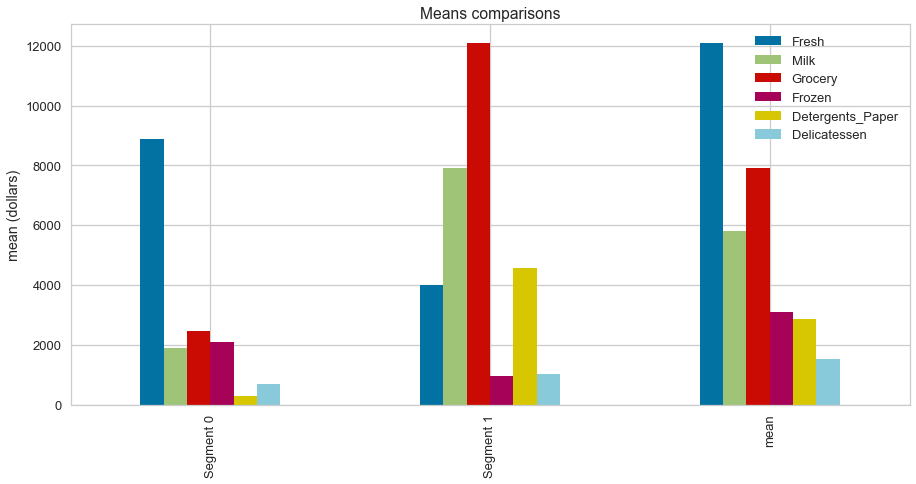

In [37]:
def plot_mean_comparisons(clust_means, data, figsize=(13, 7)):
    
    means = clust_means.append(data.describe().loc['mean'])
    means.plot(kind='bar', figsize=figsize)

    plt.ylabel('mean (dollars)')
    plt.title('Means comparisons')
    plt.tight_layout()

plot_mean_comparisons(true_centers, np.exp(good_data))

******* Key *******
stars    = segment means
diamonds = sample points
  green  = Deli
  yellow = Large produce-oriented market
  cyan   = Medium-sized grocery store


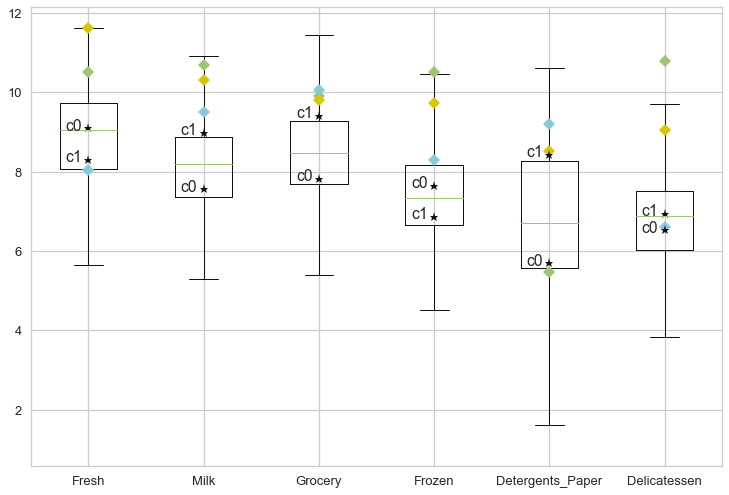

In [38]:
SAMPLE_LABELS = ['Deli','Large produce-oriented market',
                 'Medium-sized grocery store']

print draw_boxplots(data=good_data,
                    samples=log_samples,
                    cluster_centers=log_centers,
                    column_labels=good_data.columns,
                    sample_labels=SAMPLE_LABELS)
plt.tight_layout()

### Question 9

*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [39]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

print
display(samples)  # for reference

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
183,36847,43950,20170,36534,239,47943
181,112151,29627,18148,16745,4948,8550
200,3067,13240,23127,3941,9959,731


**Answer:**

Guessed segments from Question 1 with cluster predictions:
- `[0]:` Deli
    - Predicted segment 1: Medium to large grocery store
- `[1]:` Large produce-oriented market
    - Predicted segment 1: Medium to large grocery store
- `[2]:` Medium-sized grocery store
    - Predicted segment 1: Medium to large grocery store
    
Discussion:
- These predictions from our clustering algorithm match up well with my estimates with the exception of the first sample.
    - The first sample, which I assessed to be a deli-like establishment would not exactly match up with Segment 0 for smaller establishments, but it not as good of a fit with Segment 1 like the other two samples are.
    - However, the segment prediction for this sample does make sense in light of it's drastically high Deli spending.
    - This could be a result of poorly-defined clusters or, more likely, because of my poor initial assessments of the samples (due to my assumption that all customers were retail establishments, not considering restaurants as possible customers as well).

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10

Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

The wholesaler could try the new delivery schedule for a slice of each segments, and if one segment reacts significantly more positively to the change, it could be assumed that the other customers in that segment would also react positively.

Since our segments are not well-defined, I would suggest that the wholesaler test the new delivery schedule on another slice of one or both of the segments, depending on the results of the first test.

### Question 11

Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

- One could simply use the K-Means `clusterer` that has already been trained on the data to predict segments for new data. 
- This would be done in the same way as our original data was labelled. 
- New data would need to be logarithmically scaled and run through the already-fit `clusterer_6d` instance to generate a segment prediction (our target variable).

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

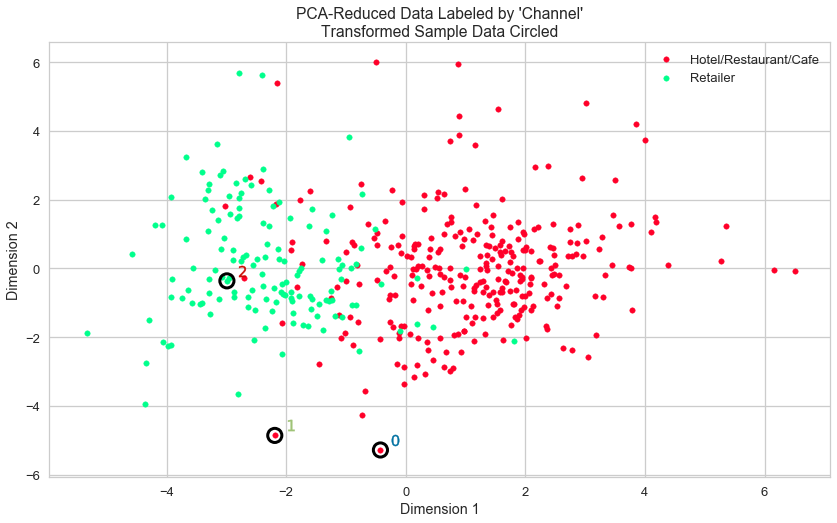

In [40]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data_2d, outliers.index, reduced_samples_2d)

### Question 12

*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

- The K-Means algorithm parameterized for 2 clusters lines up with this hidden feature fairly well.
- However, neither segment would consist purely of 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution
- My definitions of the customer segments (as well as estimatations throughout this project) _only_ included categories of retailers and not establishments that primarily serve prepared food. Thus, classifications indicated by the hidden variables did not match with my definitions.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.